In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/Homeworks/HW1/

/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Homeworks/HW1


# Regression of car prices from car features
The goal is to come up with a predictive model for prices of cars based on different features of cars. We want to understand the factors on which the pricing of cars depends i.e. what factors affect the pricing of cars. The dataset can be downloaded from:

https://www.kaggle.com/goyalshalini93/car-data

Data consists of both Categorical and Numerical Entries. We will only use the numerical entries for prediction for simplicity. You may (in the future) convert the categorical entries to numerical ones to improve prediction accuracy. The columns are the features of the car, including its price. You will regress the car price from the other features.

Several features of the cars are given in the attached spreadsheet. You will use the nuumerical features to make the prediction. The goal is to obtain good predictions using minimum number of predictors, which will improve interpretability.

<font color=red>You have to complete the sections of the code below.</font>

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd


### Download the data
1. Drop rows with NAN entries
2. Scale the features
3. Add a constant feature; car prices often has a baseline. This can be omitted for the extra-credit part with mean subtraction


In [4]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head(10)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.000
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.000
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.000
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.000
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.000
5,6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.000
6,7,1,audi 100ls,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710.000
7,8,1,audi 5000,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920.000
8,9,1,audi 4000,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875.000
9,10,0,audi 5000s (diesel),gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,17859.167


## Preprocessing the data

Remove any NAN entries, extract the target field, and scale the data

In [5]:
# Keep only the numerical fields for convenience. Omit categorical fields
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]

# Drop training vectors with NAN entries
data.dropna(axis=0, how='any',inplace=True)

# Extract the target field
y = data['price'].to_numpy()

# Remove the target and ID fields from X
datanew = data.drop(['price'],axis=1)
X = datanew.to_numpy()
# Scale the data to make their variance one
X = scale(X,with_mean='False')

# Add a constant column to the features to account for baseline
n,m = X.shape
X0 = np.ones((n,1))
X = np.hstack((X,X0))

# Verify that sale price is eliminated
print('Size of Pre-processed data',X.shape)
#Display the  dataset after dropping the price
datanew.head(3)

Size of Pre-processed data (205, 16)


<ipython-input-5-3efb53657b15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, how='any',inplace=True)


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26


# Visualizing the data

We will load the variables to the matrix $\mathbf X$ and the prices to the vector $y$. We will seek to express the price vector $y$ as a weighted linear combination of the variables denoted by the columns of $\mathbf X$

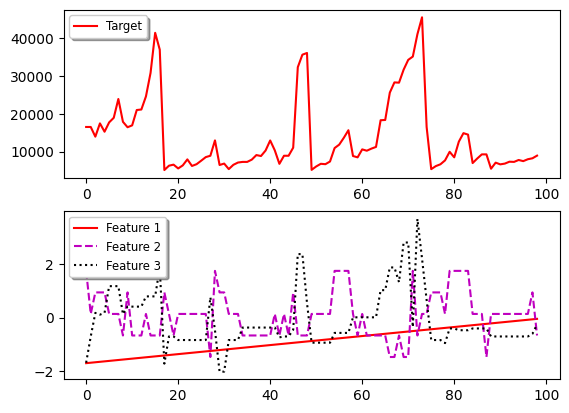

In [6]:
fig, ax = plt.subplots(2, 1)
c=ax[0].plot(y[1:100],'r',label='Target')
l = ax[0].legend(loc='upper left', shadow=True, fontsize='small')

c=ax[1].plot(X[1:100,0],'r',label='Feature 1')
c=ax[1].plot(X[1:100,1],'m--',label='Feature 2')
c=ax[1].plot(X[1:100,2],'k:',label='Feature 3')
legend = ax[1].legend(loc='upper left', shadow=True, fontsize='small')




## Split into training and validation datasets

<font color=red>Modify the code below </font>

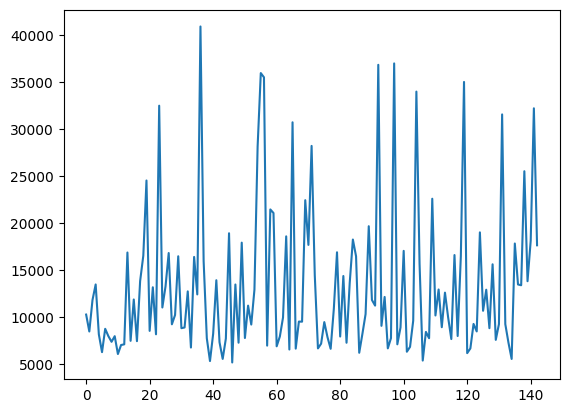

In [7]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
s=plt.plot(y_train)


## 1.(a) Ridge Regression of car prices

We assume that the car prices (y) can be predicted as

$$y = a_0 x_0 + \ldots a_{9} x_{9}+.., $$

where $a_1,..a_{9},..$ are the coefficients and $x_0 .. x_9 ..$ are the car features. Specifically, we are trying to express the category vector as the weighted linear combination of the other curves. The weights are the factors.

We first create the matrix X_train, whose columns are the normalized training features. We will solve for a using ridge regression as

$$\mathbf a = \arg \min_{\boldsymbol \theta}\|\mathbf X\boldsymbol \theta - \mathbf y\|^2 + \alpha \|\boldsymbol \theta\|_2^2$$

<font color=red>WITHOUT using Scikit learn, construct the matrix X and compute the coefficients in for arbitrary choice of regularization parameter ɑ. Complete the fit and predict methods. </font>



In [8]:
class ridgereg():
  def __init__(self,alpha):
    self.alpha = alpha

  def fit(self,X,y):

    # Compute theta
    I = np.identity(X.shape[1])
    self.theta = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y

    return self

  def predict(self,X):
    # Compute prediction
    self.pred = X @ self.theta

    return self.pred

## Ridge regression with $\alpha=100$

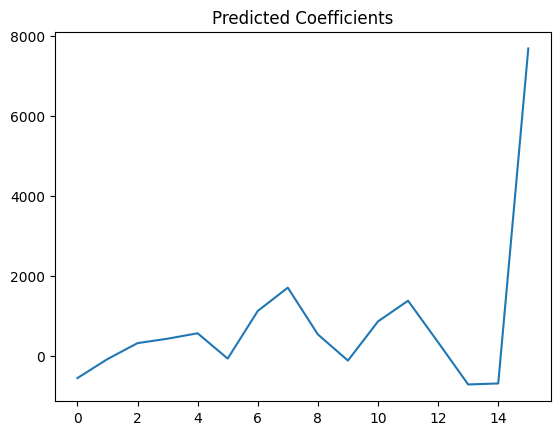

In [9]:
reg = ridgereg(alpha=100)
reg.fit(X_train,y_train)

coefficients = reg.theta
plt.plot(coefficients)
s=plt.title('Predicted Coefficients')


## 1.(a) Prediction

Perform prediction and compare to the actual prices

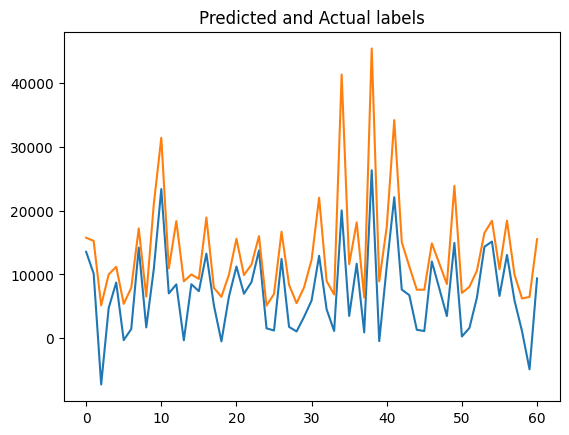

In [10]:
prediction = reg.predict(X_test)

fig = plt.figure()
ax = fig.gca()
plt.plot(prediction[1:100])

plt.plot(y_test[1:100])
s=plt.title('Predicted and Actual labels')


## 1.(b). Regularization parameter selection; ridge regression using scikit learn

We will now determinee the best regularization parameter, which would hopefully reduce the overfitting issue. We will now use ridge regression from Scikit learn for this purpose. See https://scikit-learn.org/stable/ for documentation. Specifically, the coefficients are learned from training data for different parameters, while the error on the validation data is used to determine the optimal parameter. By thresholding the coefficients, you will select the most significant and least significant predictors. This function also solves

$$\mathbf a = \arg \min_{\mathbf a}\|\mathbf X\mathbf a - \mathbf y\|^2 + \alpha \|\mathbf a\|_2^2$$

as with 1.(a).

We will store the coefficients, test error, and training error for a range of regularization parameters (denoted by alpha). Note that with $\alpha>0$, the coefficient values will be pushed closer to zero.

The plot of coefficients vs alpha will show when each of the coeffients become zero. Similarly, we can also observe the trend of the training and validation error

<ipython-input-11-f30334511040>:43: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(coefs[:][4],use_line_collection=True)


Text(0.5, 1.0, 'Ridge Regression Coefficients')

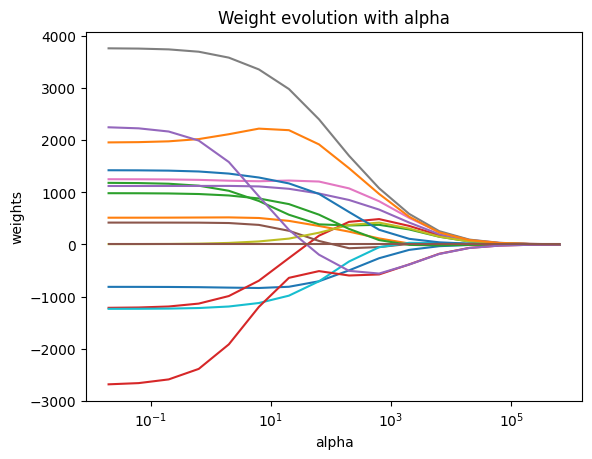

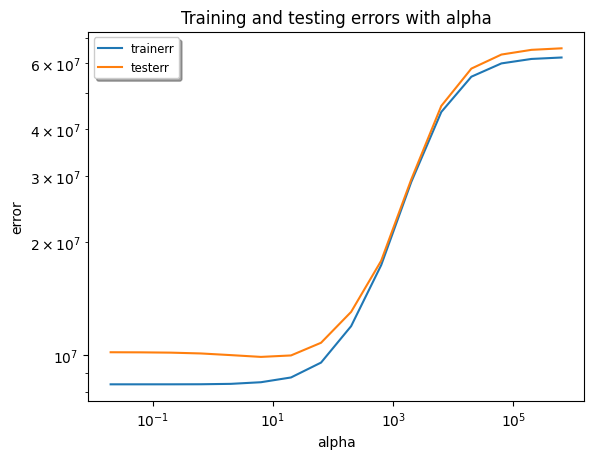

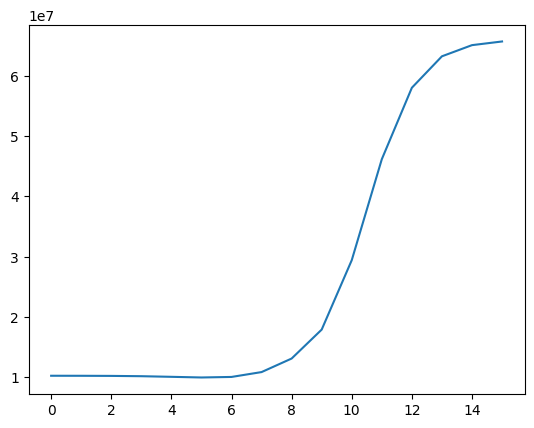

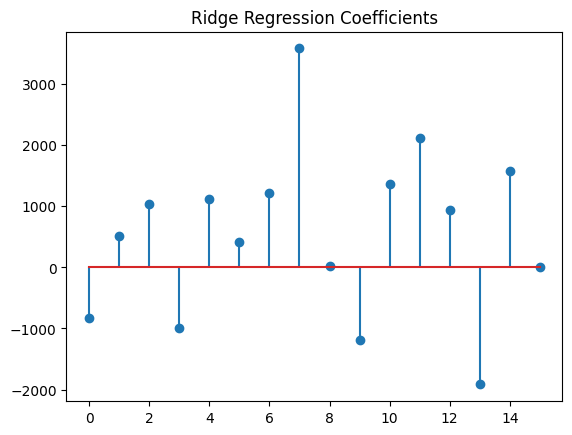

In [11]:
from sklearn.linear_model import Ridge
alphas = 10**np.arange(-2,6,0.5)
ridge = Ridge(max_iter = 10000)

coefs = []
testerr = []
trainerr = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    testerr.append(mean_squared_error(y_test, ridge.predict(X_test)))
    trainerr.append(mean_squared_error(y_train, ridge.predict(X_train)))

fig1 = plt.figure()
ax = fig1.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Weight evolution with alpha')

fig2 = plt.figure()
ax2 = fig2.gca()
ax2.plot(alphas*2, trainerr,label='trainerr')
ax2.plot(alphas*2, testerr,label='testerr')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('error')
legend = ax2.legend(loc='upper left', shadow=True, fontsize='small')
plt.title('Training and testing errors with alpha')


fig3 = plt.figure()
plt.plot(testerr)

# Plot the minimum point in the testing error
fig4 = plt.figure()
plt.stem(coefs[:][4],use_line_collection=True)
plt.title('Ridge Regression Coefficients')

## 1.c Pick important predictors; pick coefficients greater than a threshold
We will now list the important indices. We choose a threshold of 1000 in this case. You may play with this number. Put your money on these attributes. Likewise, we will insignificant coefficients are the less than a threshold

In [12]:
min_validation_error_index = 4
coefs = coefs[min_validation_error_index][0:-1]

indices = np.nonzero(np.abs(coefs)>1000)
names = datanew.columns
print('Significant Indices',names[indices])

indices = np.nonzero(np.abs(coefs)<=1000)
names = datanew.columns
print('InSignificant Indices',names[indices])

Significant Indices Index(['wheelbase', 'carwidth', 'curbweight', 'enginesize', 'stroke',
       'compressionratio', 'horsepower', 'citympg', 'highwaympg'],
      dtype='object')
InSignificant Indices Index(['car_ID', 'symboling', 'carlength', 'carheight', 'boreratio',
       'peakrpm'],
      dtype='object')
